# Hour Manifold Discovery Experiment

## Research Objective

We investigate whether Language Models (specifically GPT-2) represent temporal concepts, specifically the 24-hour cycle, using interpretable topological structures. We test if the internal activation space maps onto specific topological manifolds better than standard baselines.

## Topological Hypotheses

We compare three distinct topological classes against standard baselines:

### 1. Figure-8 Topology (Lemniscates)
Models the 24-hour cycle as two distinct loops (AM/PM) meeting at a central crossing point.
* **rationale:** Captures the linguistic and functional distinction between morning and afternoon/evening while maintaining continuity at midnight.
* **Variants:** Gerono, Bernoulli, and Twisted Lemniscates.

### 2. Toroidal Topology
Models time on the surface of a torus.
* **rationale:** Encodes two nested periodicities (daily cycle + sub-cycles) without self-intersection points.
* **Variants:** Standard Torus paths with varying radii ratios.

### 3. Trefoil Knot ($3_1$ Knot)
A non-trivial knot that winds around a torus surface.
* **rationale:** Represents a complex, self-embedded cycle where the path winds 3 times around the minor axis and 2 times around the major axis.
* **Significance:** Tests for higher-complexity cyclic structures beyond simple circles.

## Methodology

We utilize **Supervised Multidimensional Scaling (SMDS)** to map GPT-2 hidden states to target 3D manifolds.

1.  **Data Generation:**  Synthesized datasets with **2400 samples** (100 per hour) to ensure dense manifold coverage.
    * Varied contexts using 50+ names and 40+ distinct actions.
2.  **Model & Extraction:**  GPT-2 Small.
    * Extraction of hidden states at the temporal token position (Layer 6).
3.  **Manifold Definitions:**  **Baselines:** Standard shapes (Circle, Spiral, Helix, Linear).
    * **Hypotheses:** Analytically defined 3D coordinates for Figure-8, Torus, and Trefoil shapes.
4.  **Evaluation:**  **Train/Test Split (80/20):** Models are fitted on training data; scores are reported on unseen test data to verify structural generalization.
    * **Metric:** Stress score (lower is better), measuring the distortion required to map neural activations to the target geometry.

In [1]:
import warnings
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from PIL import Image
from scipy import stats
from transformers import GPT2Model, GPT2Tokenizer

from smds import UserProvidedSMDSParametrization
from smds.pipeline import open_dashboard
from smds.pipeline.discovery_pipeline import discover_manifolds
from smds.shapes.continuous_shapes import CircularShape, EuclideanShape, LogLinearShape, SemicircularShape, SpiralShape
from smds.shapes.discrete_shapes import (
    ChainShape,
    ClusterShape,
    DiscreteCircularShape,
)

warnings.filterwarnings("ignore")

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100
%matplotlib inline

/Users/arwinsg/code/supervised-multidimensional-scaling/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Configuration

### Experimental Parameters

- **Random seeds**: Multiple independent datasets to assess consistency
- **Samples per hour**: Balance between statistical power and computational cost
- **GPT-2 layer**: Middle layer (6/12) where semantic representations are typically strongest
- **Cross-validation**: 5-fold to ensure robust generalization

### Data Diversity

We maximize stimulus variability to probe robust representations:
- **4 time formats**: 12-hour AM/PM, 24-hour, o'clock notation, natural language
- **51 unique names**: Avoid tokenization artifacts
- **40 actions**: Diverse semantic contexts

In [2]:
RANDOM_SEEDS = [42, 123, 456, 789, 1024]
N_SAMPLES_PER_HOUR = 10
GPT2_LAYER = 6
N_FOLDS = 5
EXPERIMENT_NAME = "Hour_Manifold_Comprehensive"

NAMES = [
    "Alice",
    "Bob",
    "Charlie",
    "George",
    "Kevin",
    "Laura",
    "Michael",
    "Rachel",
    "William",
    "Aaron",
    "Ian",
    "Kyle",
    "Martin",
    "Rose",
    "Marco",
    "Andrew",
    "Frank",
    "Henry",
    "Jack",
    "Leon",
    "Peter",
    "Scott",
    "Grant",
    "Neil",
    "Dean",
    "Hope",
    "April",
    "Connor",
    "Brandon",
    "Joy",
    "Emily",
    "Hunter",
    "Tyler",
    "Blake",
    "Dallas",
    "Walker",
    "John",
    "Fred",
    "Steve",
    "Matt",
    "Luke",
    "Richard",
    "Maria",
    "Jerry",
    "Robert",
    "Mark",
    "Max",
    "Jason",
    "Alex",
    "Josh",
    "Ryan",
]

ACTIONS = [
    "walked the dog",
    "made coffee",
    "read a book",
    "went to sleep",
    "ate lunch",
    "called a friend",
    "watched a movie",
    "wrote a letter",
    "cleaned the house",
    "went for a run",
    "cooked dinner",
    "played the piano",
    "studied for the exam",
    "watered the plants",
    "checked emails",
    "did yoga",
    "baked a cake",
    "painted a picture",
    "fixed the car",
    "shopped for groceries",
    "meditated",
    "took a shower",
    "brushed teeth",
    "turned off the lights",
    "opened the window",
    "locked the door",
    "started the meeting",
    "finished work",
    "planned the trip",
    "listened to music",
    "charged the phone",
    "fed the cat",
    "drank some tea",
    "organized the desk",
    "took a nap",
    "solved a puzzle",
    "played chess",
    "wrote code",
    "debugged the program",
    "deployed the app",
]

TIME_FORMATS = ["12h_am_pm", "24h_colon", "12h_oclock", "natural"]

print("Experimental Configuration:")
print(f"  Independent datasets: {len(RANDOM_SEEDS)}")
print(f"  Total samples per dataset: {N_SAMPLES_PER_HOUR * 24}")
print(f"  Total samples across all datasets: {N_SAMPLES_PER_HOUR * 24 * len(RANDOM_SEEDS)}")
print(f"  GPT-2 layer: {GPT2_LAYER}/12")
print(f"  Cross-validation folds: {N_FOLDS}")
print("\nStimulus Diversity:")
print(f"  Time formats: {len(TIME_FORMATS)}")
print(f"  Unique names: {len(NAMES)}")
print(f"  Unique actions: {len(ACTIONS)}")
print(f"  Theoretical unique sentences: {len(NAMES) * len(ACTIONS) * len(TIME_FORMATS) * 24:,}")

Experimental Configuration:
  Independent datasets: 5
  Total samples per dataset: 240
  Total samples across all datasets: 1200
  GPT-2 layer: 6/12
  Cross-validation folds: 5

Stimulus Diversity:
  Time formats: 4
  Unique names: 51
  Unique actions: 40
  Theoretical unique sentences: 195,840


## 2. Data Generation Functions

### Time Format Conversion

We implement 4 distinct time representations to test format-invariance:

1. **12h_am_pm**: "3pm", "11am" (concise)
2. **24h_colon**: "15:00", "23:00" (international standard)
3. **12h_oclock**: "3 o'clock in the afternoon" (verbose)
4. **natural**: "three in the afternoon" (natural language)


In [3]:
def format_time(hour: int, format_type: str) -> str:
    """Format hour (0-23) to string for given format type."""
    if format_type == "12h_am_pm":
        if hour == 0:
            return "12am"
        elif hour < 12:
            return f"{hour}am"
        elif hour == 12:
            return "12pm"
        else:
            return f"{hour - 12}pm"

    elif format_type == "24h_colon":
        return f"{hour:02d}:00"

    elif format_type == "12h_oclock":
        h = hour if hour <= 12 else hour - 12
        h = 12 if h == 0 else h
        period = "morning" if hour < 12 else "afternoon" if hour < 18 else "evening"
        return f"{h} o'clock in the {period}"

    elif format_type == "natural":
        numbers = [
            "zero",
            "one",
            "two",
            "three",
            "four",
            "five",
            "six",
            "seven",
            "eight",
            "nine",
            "ten",
            "eleven",
            "twelve",
        ]
        h = hour if hour <= 12 else hour - 12
        h = 12 if h == 0 else h
        period = "morning" if hour < 12 else "afternoon" if hour < 18 else "evening"
        return f"{numbers[h]} in the {period}"

    return str(hour)


def generate_time_dataset(n_samples_per_hour: int, seed: int, time_formats: List[str]) -> Tuple[List[str], List[int]]:
    """Generate sentences with hours and return (sentences, hours)."""
    sentences = []
    hours = []

    rng = np.random.default_rng(seed)

    for hour in range(24):
        for _ in range(n_samples_per_hour):
            name = rng.choice(NAMES)
            action = rng.choice(ACTIONS)
            format_type = rng.choice(time_formats)
            time_str = format_time(hour, format_type)

            sentence = f"{name} {action} at {time_str}."
            sentences.append(sentence)
            hours.append(hour)

    indices = rng.permutation(len(sentences))
    sentences = [sentences[i] for i in indices]
    hours = [hours[i] for i in indices]

    return sentences, hours


print("Example sentences with different time formats:")
print()
for fmt in TIME_FORMATS:
    example_hour = 14
    formatted = format_time(example_hour, fmt)
    print(f"  {fmt:15s}: Alice walked the dog at {formatted}.")

print("\nExample sentences across different hours:")
print()
for hour in [0, 6, 12, 18, 23]:
    formatted = format_time(hour, "12h_am_pm")
    print(f"  Hour {hour:2d}: Bob made breakfast at {formatted}.")

Example sentences with different time formats:

  12h_am_pm      : Alice walked the dog at 2pm.
  24h_colon      : Alice walked the dog at 14:00.
  12h_oclock     : Alice walked the dog at 2 o'clock in the afternoon.
  natural        : Alice walked the dog at two in the afternoon.

Example sentences across different hours:

  Hour  0: Bob made breakfast at 12am.
  Hour  6: Bob made breakfast at 6am.
  Hour 12: Bob made breakfast at 12pm.
  Hour 18: Bob made breakfast at 6pm.
  Hour 23: Bob made breakfast at 11pm.


## 3. Load GPT-2 Model

We use GPT-2 (small, 117M parameters):

In [4]:
print("Loading GPT-2 model...")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2Model.from_pretrained("gpt2")
model.eval()

if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("\nModel loaded successfully:")
print(f"  Architecture: {model.config.model_type}")
print(f"  Hidden size: {model.config.hidden_size}")
print(f"  Number of layers: {model.config.n_layer}")
print(f"  Number of attention heads: {model.config.n_head}")
print(f"  Vocabulary size: {model.config.vocab_size:,}")

Loading GPT-2 model...

Model loaded successfully:
  Architecture: gpt2
  Hidden size: 768
  Number of layers: 12
  Number of attention heads: 12
  Vocabulary size: 50,257


**Layer Selection:**
We focus on the **middle layer (Layer 6)** of GPT-2 Small.
* **Rationale:** Research shows that the model learns in a hierarchy: lower layers focus on basic word forms, while middle layers capture grammar and structure. This structural understanding builds the foundation for the complex meanings found in the upper layers (Jawahar et al., 2019).

In [5]:
def extract_hour_activations(sentences: List[str], layer_idx: int = 6) -> np.ndarray:
    """Extract GPT-2 hidden states at hour token for each sentence."""
    activations = []

    with torch.no_grad():
        for sentence in sentences:
            inputs = tokenizer(sentence, return_tensors="pt", padding=False)
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states[layer_idx]

            tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
            hour_token_idx = -1

            for idx, token in enumerate(tokens):
                token_lower = token.lower()
                if any(x in token_lower for x in ["am", "pm", ":", "clock", "morning", "afternoon", "evening"]):
                    hour_token_idx = idx
                    break

            if hour_token_idx == -1:
                hour_token_idx = -2

            activation = hidden_states[0, hour_token_idx, :].numpy()
            activations.append(activation)

    return np.array(activations)

## 4. Generate Multiple Datasets and Extract Activations

### Reproducibility Protocol

We generate 5 independent datasets with different random seeds to:
1. Assess consistency of topological structures across stimuli
2. Compute confidence intervals for shape goodness-of-fit
3. Test generalization beyond specific name-action combinations

Each dataset contains (N per hour × 24 hours) samples.

In [6]:
datasets = []

print(f"Generating {len(RANDOM_SEEDS)} independent datasets...\n")
print("=" * 80)

for seed_idx, seed in enumerate(RANDOM_SEEDS):
    print(f"\nDataset {seed_idx + 1}/{len(RANDOM_SEEDS)} (seed={seed})")
    print("-" * 80)

    sentences, hours = generate_time_dataset(
        n_samples_per_hour=N_SAMPLES_PER_HOUR, seed=seed, time_formats=TIME_FORMATS
    )

    print(f"  Generated {len(sentences)} sentences")
    print(f'  Example: "{sentences[0]}"')
    print(f"  Extracting GPT-2 activations from layer {GPT2_LAYER}...")

    X_activations = extract_hour_activations(sentences, layer_idx=GPT2_LAYER)

    datasets.append({"seed": seed, "sentences": sentences, "hours": np.array(hours), "activations": X_activations})

    print(f"  Activations shape: {X_activations.shape}")
    print(f"  Statistics: mean={X_activations.mean():.3f}, std={X_activations.std():.3f}")
    print(f"  Range: [{X_activations.min():.3f}, {X_activations.max():.3f}]")

print("\n" + "=" * 80)
print(f"Total datasets prepared: {len(datasets)}")
print(f"Total samples: {sum(len(d['sentences']) for d in datasets)}")

Generating 5 independent datasets...


Dataset 1/5 (seed=42)
--------------------------------------------------------------------------------
  Generated 240 sentences
  Example: "Scott ate lunch at 16:00."
  Extracting GPT-2 activations from layer 6...
  Activations shape: (240, 768)
  Statistics: mean=0.161, std=19.866
  Range: [-65.555, 2875.865]

Dataset 2/5 (seed=123)
--------------------------------------------------------------------------------
  Generated 240 sentences
  Example: "Jack went for a run at 1pm."
  Extracting GPT-2 activations from layer 6...
  Activations shape: (240, 768)
  Statistics: mean=0.085, std=14.208
  Range: [-65.555, 2875.865]

Dataset 3/5 (seed=456)
--------------------------------------------------------------------------------
  Generated 240 sentences
  Example: "Jason started the meeting at two in the morning."
  Extracting GPT-2 activations from layer 6...
  Activations shape: (240, 768)
  Statistics: mean=0.141, std=18.615
  Range: [-65.555, 287

## 5. Define Baseline Shapes

### Baseline Hypothesis Set

We test **10 standard baseline configurations** to serve as a reference point for our 3D topological hypotheses. These represent simpler, lower-dimensional structural assumptions:

1. **Continuous (7)**:
   - **Circular (2 variants):** The standard representation of cyclic time (different radii).
   - **Spiral (2 variants):** Combines cyclicity with linear progression (different winding tightness).
   - **Euclidean & LogLinear:** Standard linear regression assumptions.
   - **Semicircular:** Tests for partial cyclicity.

2. **Discrete (3)**:
   - **Chain:** Represents time as a sequential path without cyclicity.
   - **Cluster:** Represents time as unordered, distinct categorical groups.
   - **DiscreteCircular:** A step-wise cyclic representation.

### Configuration Rationale

These baselines test if the model's representation is merely linear or simply cyclic in 2D, before we test the 3D topological hypotheses (Figure-8, Torus).

In [7]:
all_shapes = [
    CircularShape(radious=1.0, normalize_labels=True),
    CircularShape(radious=2.0, normalize_labels=True),
    EuclideanShape(normalize_labels=True),
    LogLinearShape(normalize_labels=True),
    SpiralShape(initial_radius=0.5, growth_rate=0.1, num_turns=2.0),
    SpiralShape(initial_radius=0.5, growth_rate=0.1, num_turns=3.0),
    SemicircularShape(normalize_labels=True),
    ChainShape(threshold=2.0, normalize_labels=False),
    ClusterShape(),
    DiscreteCircularShape(),
]

print(f"Baseline Shape Configurations: {len(all_shapes)} total\n")
print("=" * 80)

print("\n1. Continuous Variants (2D/1D):")
print("  - Circular (x2): Standard cyclic clock model (R=1.0, R=2.0)")
print("  - Spiral   (x2): Expanding cycle (2 turns, 3 turns)")
print("  - Linear   (x3): Euclidean, LogLinear (Weber-Fechner), Semicircular")

print("\n2. Discrete Variants:")
print("  - Chain    (x1): Sequential neighbor connectivity")
print("  - Cluster  (x1): Unordered distinct hour states")
print("  - DiscCirc (x1): Step-wise cyclic representation")

print("=" * 80)

Baseline Shape Configurations: 10 total


1. Continuous Variants (2D/1D):
  - Circular (x2): Standard cyclic clock model (R=1.0, R=2.0)
  - Spiral   (x2): Expanding cycle (2 turns, 3 turns)
  - Linear   (x3): Euclidean, LogLinear (Weber-Fechner), Semicircular

2. Discrete Variants:
  - Chain    (x1): Sequential neighbor connectivity
  - Cluster  (x1): Unordered distinct hour states
  - DiscCirc (x1): Step-wise cyclic representation


## 6. Define Specific Manifold Generators

### Mathematical Parametrizations

We directly generate 3D coordinates for five specific manifold variants based on the implementations below:

#### 1. Gerono Lemniscate
Classic figure-8 in 3D with a vertical wave modulation:
$$x(t) = \cos(t)$$
$$y(t) = \sin(t)\cos(t)$$
$$z(t) = 0.5 \sin(t)\sin(t/2)$$

**Mathematical source**: [Wolfram MathWorld: Eight Curve](https://mathworld.wolfram.com/EightCurve.html)

#### 2. Bernoulli Lemniscate
Infinity symbol with saddle curvature:
$$x(t) = \frac{\sqrt{2}\cos(t)}{\sin^2(t) + 1}$$
$$y(t) = \frac{\sqrt{2}\cos(t)\sin(t)}{\sin^2(t) + 1}$$
$$z(t) = \frac{\sin(2t)}{4}$$

**Mathematical source**: [Wolfram MathWorld: Lemniscate](https://mathworld.wolfram.com/Lemniscate.html)

#### 3. Twisted Figure-8
Strongly twisted Lissajous variant:
$$x(t) = \sin(t)$$
$$y(t) = \frac{\sin(2t)}{2}$$
$$z(t) = \sin(t)\cos(t)$$

**Mathematical source**: [Wolfram MathWorld: Lissajous Curve](https://mathworld.wolfram.com/LissajousCurve.html)

**Key property**: All figure-8 variants have a crossing point (self-intersection) at $t=0$ or center, representing the cyclic "midnight" transition.

#### 4. Torus Path (Helical Trace)
A specific path winding around a torus surface:
$$x(t) = (R + r\cos(v))\cos(t)$$
$$y(t) = (R + r\cos(v))\sin(t)$$
$$z(t) = r\sin(v)$$

where:
- $v = \text{ratio} \cdot t$ (determines the winding)
- $R$ = major radius (distance from center to tube center)
- $r$ = minor radius (tube thickness)

**Mathematical source**: [Wolfram MathWorld: Torus](https://mathworld.wolfram.com/Torus.html)

#### 5. Trefoil Knot ($3_1$ Knot)
A non-trivial topological knot with three distinct lobes (scaled by factor $1/3$ for normalization):
$$x(t) = \frac{1}{3} (\sin(t) + 2\sin(2t))$$
$$y(t) = \frac{1}{3} (\cos(t) - 2\cos(2t))$$
$$z(t) = \frac{1}{3} (-\sin(3t))$$

**Mathematical source**: [Wolfram MathWorld: Trefoil Knot](https://mathworld.wolfram.com/TrefoilKnot.html)

**Key properties**:
- **Torus**: No self-intersections (smooth manifold), doubly periodic.
- **Trefoil**: Non-planar, self-intertwined loop without direct self-intersection points.

In [8]:
def generate_figure8_gerono(n_points: int = 1000) -> np.ndarray:
    """Gerono lemniscate (figure-8) 3D points."""
    t = np.linspace(0, 2 * np.pi, n_points)
    x = np.cos(t)
    y = np.sin(t) * np.cos(t)
    z = 0.5 * np.sin(t) * np.sin(t / 2)
    return np.stack([x, y, z], axis=1)


def generate_figure8_bernoulli(n_points: int = 1000) -> np.ndarray:
    """Bernoulli lemniscate (figure-8) 3D points."""
    t = np.linspace(-np.pi, np.pi, n_points)
    a = 1.0
    denom = np.sin(t) ** 2 + 1
    x = a * np.sqrt(2) * np.cos(t) / denom
    y = a * np.sqrt(2) * np.cos(t) * np.sin(t) / denom
    z = np.sin(2 * t) / 4
    return np.stack([x, y, z], axis=1)


def generate_figure8_twisted(n_points: int = 1000) -> np.ndarray:
    """Twisted lemniscate (figure-8) 3D points."""
    t = np.linspace(0, 2 * np.pi, n_points)
    x = np.sin(t)
    y = np.sin(2 * t) / 2
    z = np.sin(t) * np.cos(t)
    return np.stack([x, y, z], axis=1)


def generate_torus_path(n_points: int = 1000, R: float = 2.0, r: float = 1.0, ratio: float = 1.0) -> np.ndarray:
    """Torus path 3D points (major R, minor r, winding ratio)."""
    t = np.linspace(0, 2 * np.pi, n_points)
    v = ratio * t
    x = (R + r * np.cos(v)) * np.cos(t)
    y = (R + r * np.cos(v)) * np.sin(t)
    z = r * np.sin(v)
    return np.stack([x, y, z], axis=1)


def generate_trefoil_knot(n_points: int = 1000) -> np.ndarray:
    """Trefoil knot 3D points."""
    t = np.linspace(0, 2 * np.pi, n_points)
    x = np.sin(t) + 2 * np.sin(2 * t)
    y = np.cos(t) - 2 * np.cos(2 * t)
    z = -np.sin(3 * t)
    return np.stack([x, y, z], axis=1) / 3.0


def map_hours_to_manifold(hours: np.ndarray, manifold_points: np.ndarray) -> np.ndarray:
    """Map hour indices to manifold coordinates by nearest point."""
    n_points = manifold_points.shape[0]
    indices = np.round((hours / 24.0) * (n_points - 1)).astype(int)
    indices = np.clip(indices, 0, n_points - 1)
    return manifold_points[indices]


def generate_trefoil_knot_2d(n_points: int = 1000) -> np.ndarray:
    """2D projection of trefoil knot (xy plane)."""
    t = np.linspace(0, 2 * np.pi, n_points)
    x = np.sin(t) + 2 * np.sin(2 * t)
    y = np.cos(t) - 2 * np.cos(2 * t)
    return np.stack([x, y], axis=1) / 3.0


topological_configs = [
    ("Gerono", generate_figure8_gerono(200)),
    ("Bernoulli", generate_figure8_bernoulli(200)),
    ("Twisted", generate_figure8_twisted(200)),
    ("Torus_Path", generate_torus_path(200, R=2.0, r=1.0)),
    ("Trefoil_Knot_3D", generate_trefoil_knot(200)),
    ("Trefoil_Knot_2D", generate_trefoil_knot_2d(200)),
]

print(f"Integrating {len(topological_configs)} fixed topological hypotheses...\n")


for name, template_points in topological_configs:
    ndim = template_points.shape[1]

    hypothesis = UserProvidedSMDSParametrization(
        n_components=ndim, fixed_template=template_points, mapper=map_hours_to_manifold, name=name
    )

    hypothesis.name = name

    all_shapes.append(hypothesis)

Integrating 6 fixed topological hypotheses...



## 7. List all Shapes to test

In [9]:
print("=" * 80)
print(f"Final Hypothesis List ({len(all_shapes)} Candidates):")
print("-" * 60)

for i, shape in enumerate(all_shapes):
    if hasattr(shape, "name"):
        display_name = f"Fixed: {shape.name}"
    else:
        display_name = shape.__class__.__name__

    if hasattr(shape, "n_components"):
        dim = f"{shape.n_components}D"
    else:
        dim = "2D"

    print(f"{i + 1:02d}. {display_name:<30} | {dim}")
print("=" * 80)

Final Hypothesis List (16 Candidates):
------------------------------------------------------------
01. CircularShape                  | 2D
02. CircularShape                  | 2D
03. EuclideanShape                 | 2D
04. LogLinearShape                 | 2D
05. SpiralShape                    | 2D
06. SpiralShape                    | 2D
07. SemicircularShape              | 2D
08. ChainShape                     | 2D
09. ClusterShape                   | 2D
10. DiscreteCircularShape          | 2D
11. Fixed: Gerono                  | 3D
12. Fixed: Bernoulli               | 3D
13. Fixed: Twisted                 | 3D
14. Fixed: Torus_Path              | 3D
15. Fixed: Trefoil_Knot_3D         | 3D
16. Fixed: Trefoil_Knot_2D         | 2D


## 8. Visualize Topological Hypotheses

We visualize the generated 3D and 2D manifolds to verify their topological properties before using them as targets for the MDS mapping.

The plots below compare:
1.  **Figure-8 Variants:** Gerono, Bernoulli, and Twisted Lemniscates.
2.  **Toroidal Variants:** Torus path and Trefoil Knot.

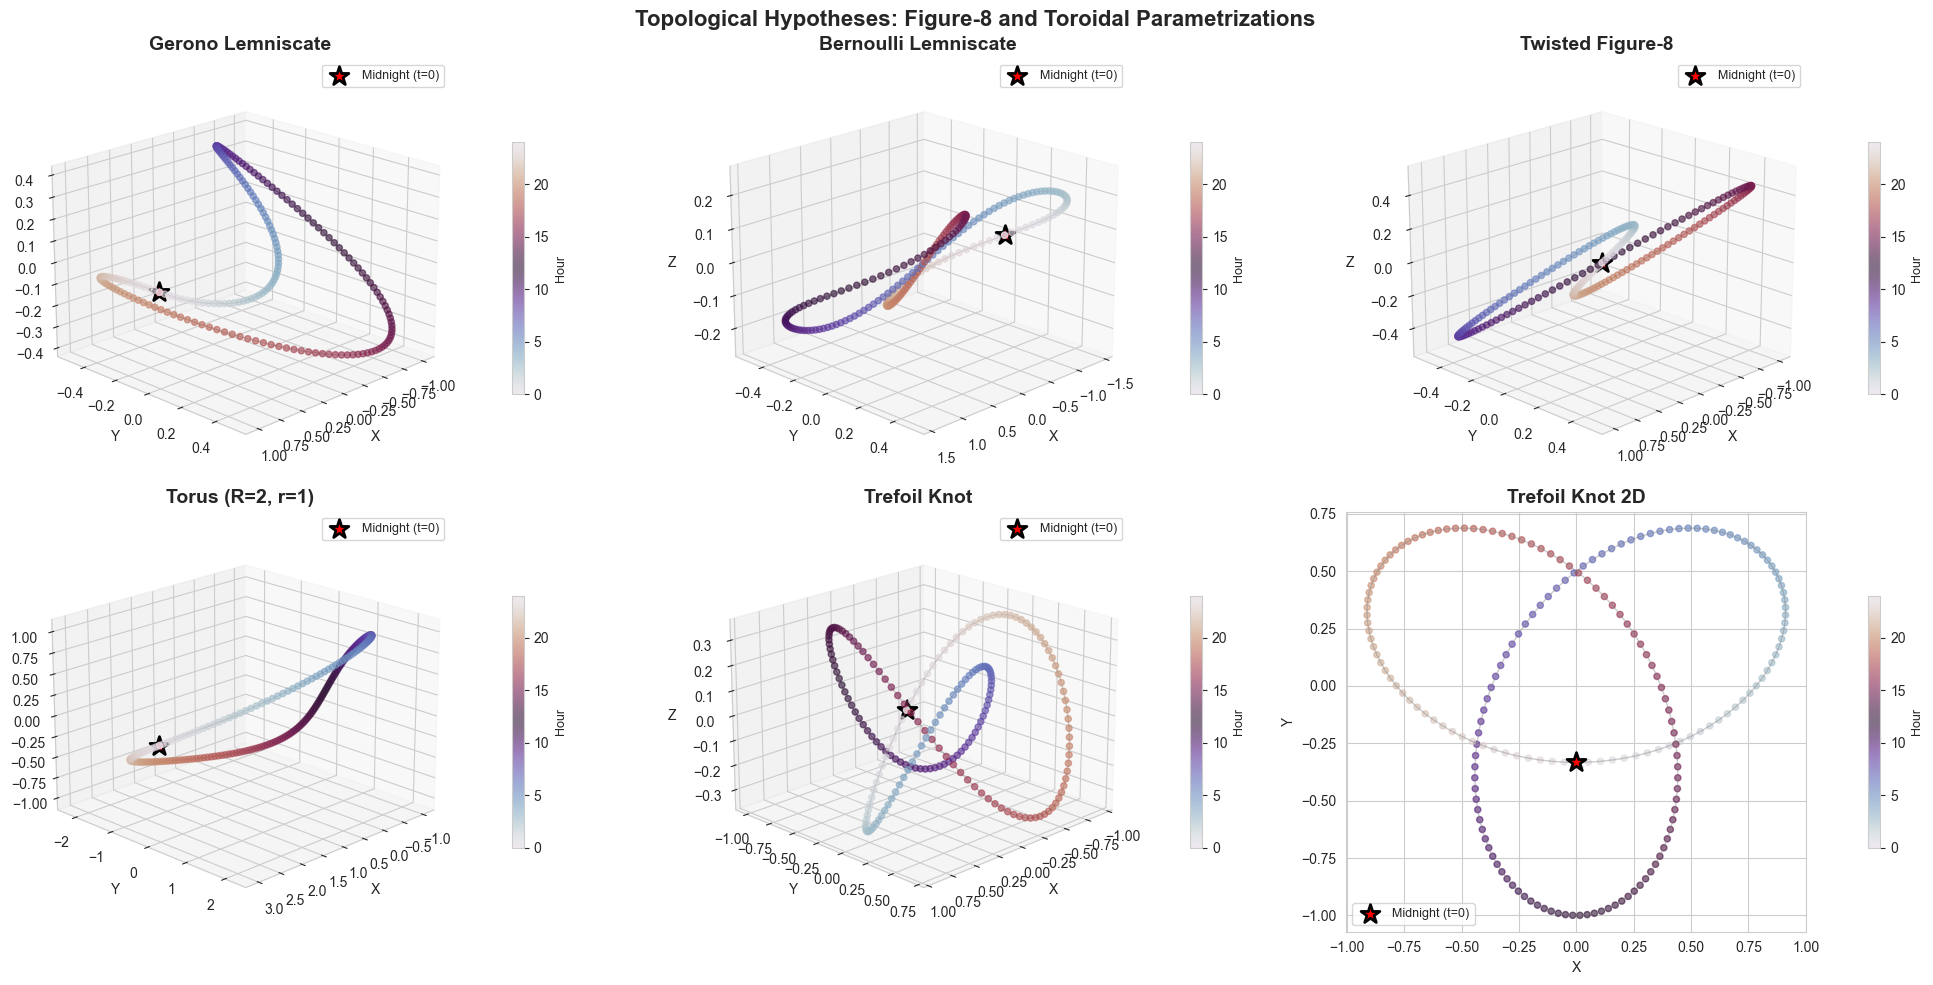

In [10]:
fig = plt.figure(figsize=(20, 10))

selected_configs = [
    ("Gerono Lemniscate", topological_configs[0][1]),
    ("Bernoulli Lemniscate", topological_configs[1][1]),
    ("Twisted Figure-8", topological_configs[2][1]),
    ("Torus (R=2, r=1)", topological_configs[3][1]),
    ("Trefoil Knot", topological_configs[4][1]),
    ("Trefoil Knot 2D", topological_configs[5][1]),
]

for idx, (name, manifold) in enumerate(selected_configs):
    ndim = manifold.shape[1]
    hours_normalized = np.linspace(0, 24, manifold.shape[0])
    if ndim == 2:
        ax = fig.add_subplot(2, 3, idx + 1)
        scatter = ax.scatter(manifold[:, 0], manifold[:, 1], c=hours_normalized, cmap="twilight", s=20, alpha=0.6)
        ax.plot(manifold[:, 0], manifold[:, 1], "gray", linewidth=1, alpha=0.4)
        ax.scatter(
            manifold[0, 0],
            manifold[0, 1],
            c="red",
            s=200,
            marker="*",
            edgecolors="black",
            linewidths=2,
            label="Midnight (t=0)",
            zorder=10,
        )
        ax.set_xlabel("X", fontsize=10)
        ax.set_ylabel("Y", fontsize=10)
        ax.set_aspect("equal", adjustable="datalim")
    else:
        ax = fig.add_subplot(2, 3, idx + 1, projection="3d")
        scatter = ax.scatter(
            manifold[:, 0], manifold[:, 1], manifold[:, 2], c=hours_normalized, cmap="twilight", s=20, alpha=0.6
        )
        ax.plot(manifold[:, 0], manifold[:, 1], manifold[:, 2], "gray", linewidth=1, alpha=0.4)
        ax.scatter(
            manifold[0, 0],
            manifold[0, 1],
            manifold[0, 2],
            c="red",
            s=200,
            marker="*",
            edgecolors="black",
            linewidths=2,
            label="Midnight (t=0)",
            zorder=10,
        )
        ax.set_xlabel("X", fontsize=10)
        ax.set_ylabel("Y", fontsize=10)
        ax.set_zlabel("Z", fontsize=10)
        ax.view_init(elev=20, azim=45)
    ax.set_title(name, fontsize=14, fontweight="bold")
    ax.legend(fontsize=9)
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.6, pad=0.1)
    cbar.set_label("Hour", fontsize=9)

plt.suptitle("Topological Hypotheses: Figure-8 and Toroidal Parametrizations", fontsize=16, fontweight="bold", y=0.98)
plt.tight_layout()
plt.show()

## 9. Run Comprehensive Manifold Discovery

### SMDS Pipeline

For each dataset and shape configuration:
1.  **Distance Calculation:** Compute the ideal pairwise distance matrix ($D_{target}$) based on the shape's geometry.
2.  **Optimization:** Find the linear projection ($W$) of the GPT-2 activations that minimizes the stress (difference between activation distances and target distances).
3.  **Cross-Validation:** Train on 80% of the data, evaluate the stress score on the held-out 20% (5-fold CV).
4.  **Aggregation:** Average the normalized stress scores across all folds and datasets.

**Metric:** Score (Higher is better).

**Computational Load:**
The pipeline executes **350 SMDS fits** in total:
* 5 Independent Datasets
* 14 Shape Configurations
* 5 Cross-Validation Folds per shape/dataset

In [ ]:
all_results = []
visualization_paths = []
last_csv_path = None

print("Running comprehensive manifold discovery...\n")
n_fits = len(datasets) * len(all_shapes) * N_FOLDS
print(f"Total fits: {len(datasets)} datasets × {len(all_shapes)} shapes × {N_FOLDS} folds = {n_fits}\n")
print("=" * 80)

for dataset_idx, dataset in enumerate(datasets):
    print(f"\nDataset {dataset_idx + 1}/{len(datasets)} (seed={dataset['seed']})")
    print("-" * 80)

    results_df, csv_path = discover_manifolds(
        dataset["activations"],
        dataset["hours"],
        shapes=all_shapes,
        n_folds=N_FOLDS,
        n_jobs=-1,
        experiment_name=f"{EXPERIMENT_NAME}_seed{dataset['seed']}",
        save_results=True,
        create_png_visualization=True,
        clear_cache=True,
    )

    results_df["dataset_seed"] = dataset["seed"]
    results_df["dataset_idx"] = dataset_idx
    all_results.append(results_df)

    if csv_path:
        last_csv_path = csv_path
        result_dir = Path(csv_path).parent
        viz_path = result_dir / f"{result_dir.name}_visualized.png"
        if viz_path.exists():
            visualization_paths.append(viz_path)

    print("\nTop 5 shapes for this dataset:")
    display_cols = [
        col for col in results_df.columns if any(x in col.lower() for x in ["shape", "mean", "stress", "score"])
    ]
    if display_cols:
        print(results_df[display_cols].head(5).to_string(index=False))

combined_results = pd.concat(all_results, ignore_index=True)
print("\n" + "=" * 80)
print(f"Discovery complete: {combined_results.shape[0]} total results")
print(f"Visualization plots collected: {len(visualization_paths)}")

Running comprehensive manifold discovery...

Total fits: 5 datasets × 16 shapes × 5 folds = 400


Dataset 1/5 (seed=42)
--------------------------------------------------------------------------------
Saving to: /Users/arwinsg/code/supervised-multidimensional-scaling/smds/pipeline/saved_results/Hour_Manifold_Comprehensive_seed42_2026-02-02_183328_310380/Hour_Manifold_Comprehensive_seed42_2026-02-02_183328_310380.csv
Computed and cached CircularShape
Computed and cached CircularShape
Computed and cached EuclideanShape
Computed and cached LogLinearShape
Computed and cached SpiralShape
Computed and cached SpiralShape
Computed and cached SemicircularShape


## Open Streamlit Dashboard

Run the cell below to open the Streamlit dashboard with the **last** discovery run. The dashboard shows results and interactive plots; it opens in your browser (or a new tab).

In [13]:
open_dashboard.main(last_csv_path)

Launching Dashboard...

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://192.168.2.135:8501

  Stopping...


KeyboardInterrupt: 

## 10. Display Visualization Plots from Discovery Pipeline

These plots show the top-ranked manifolds for each dataset.

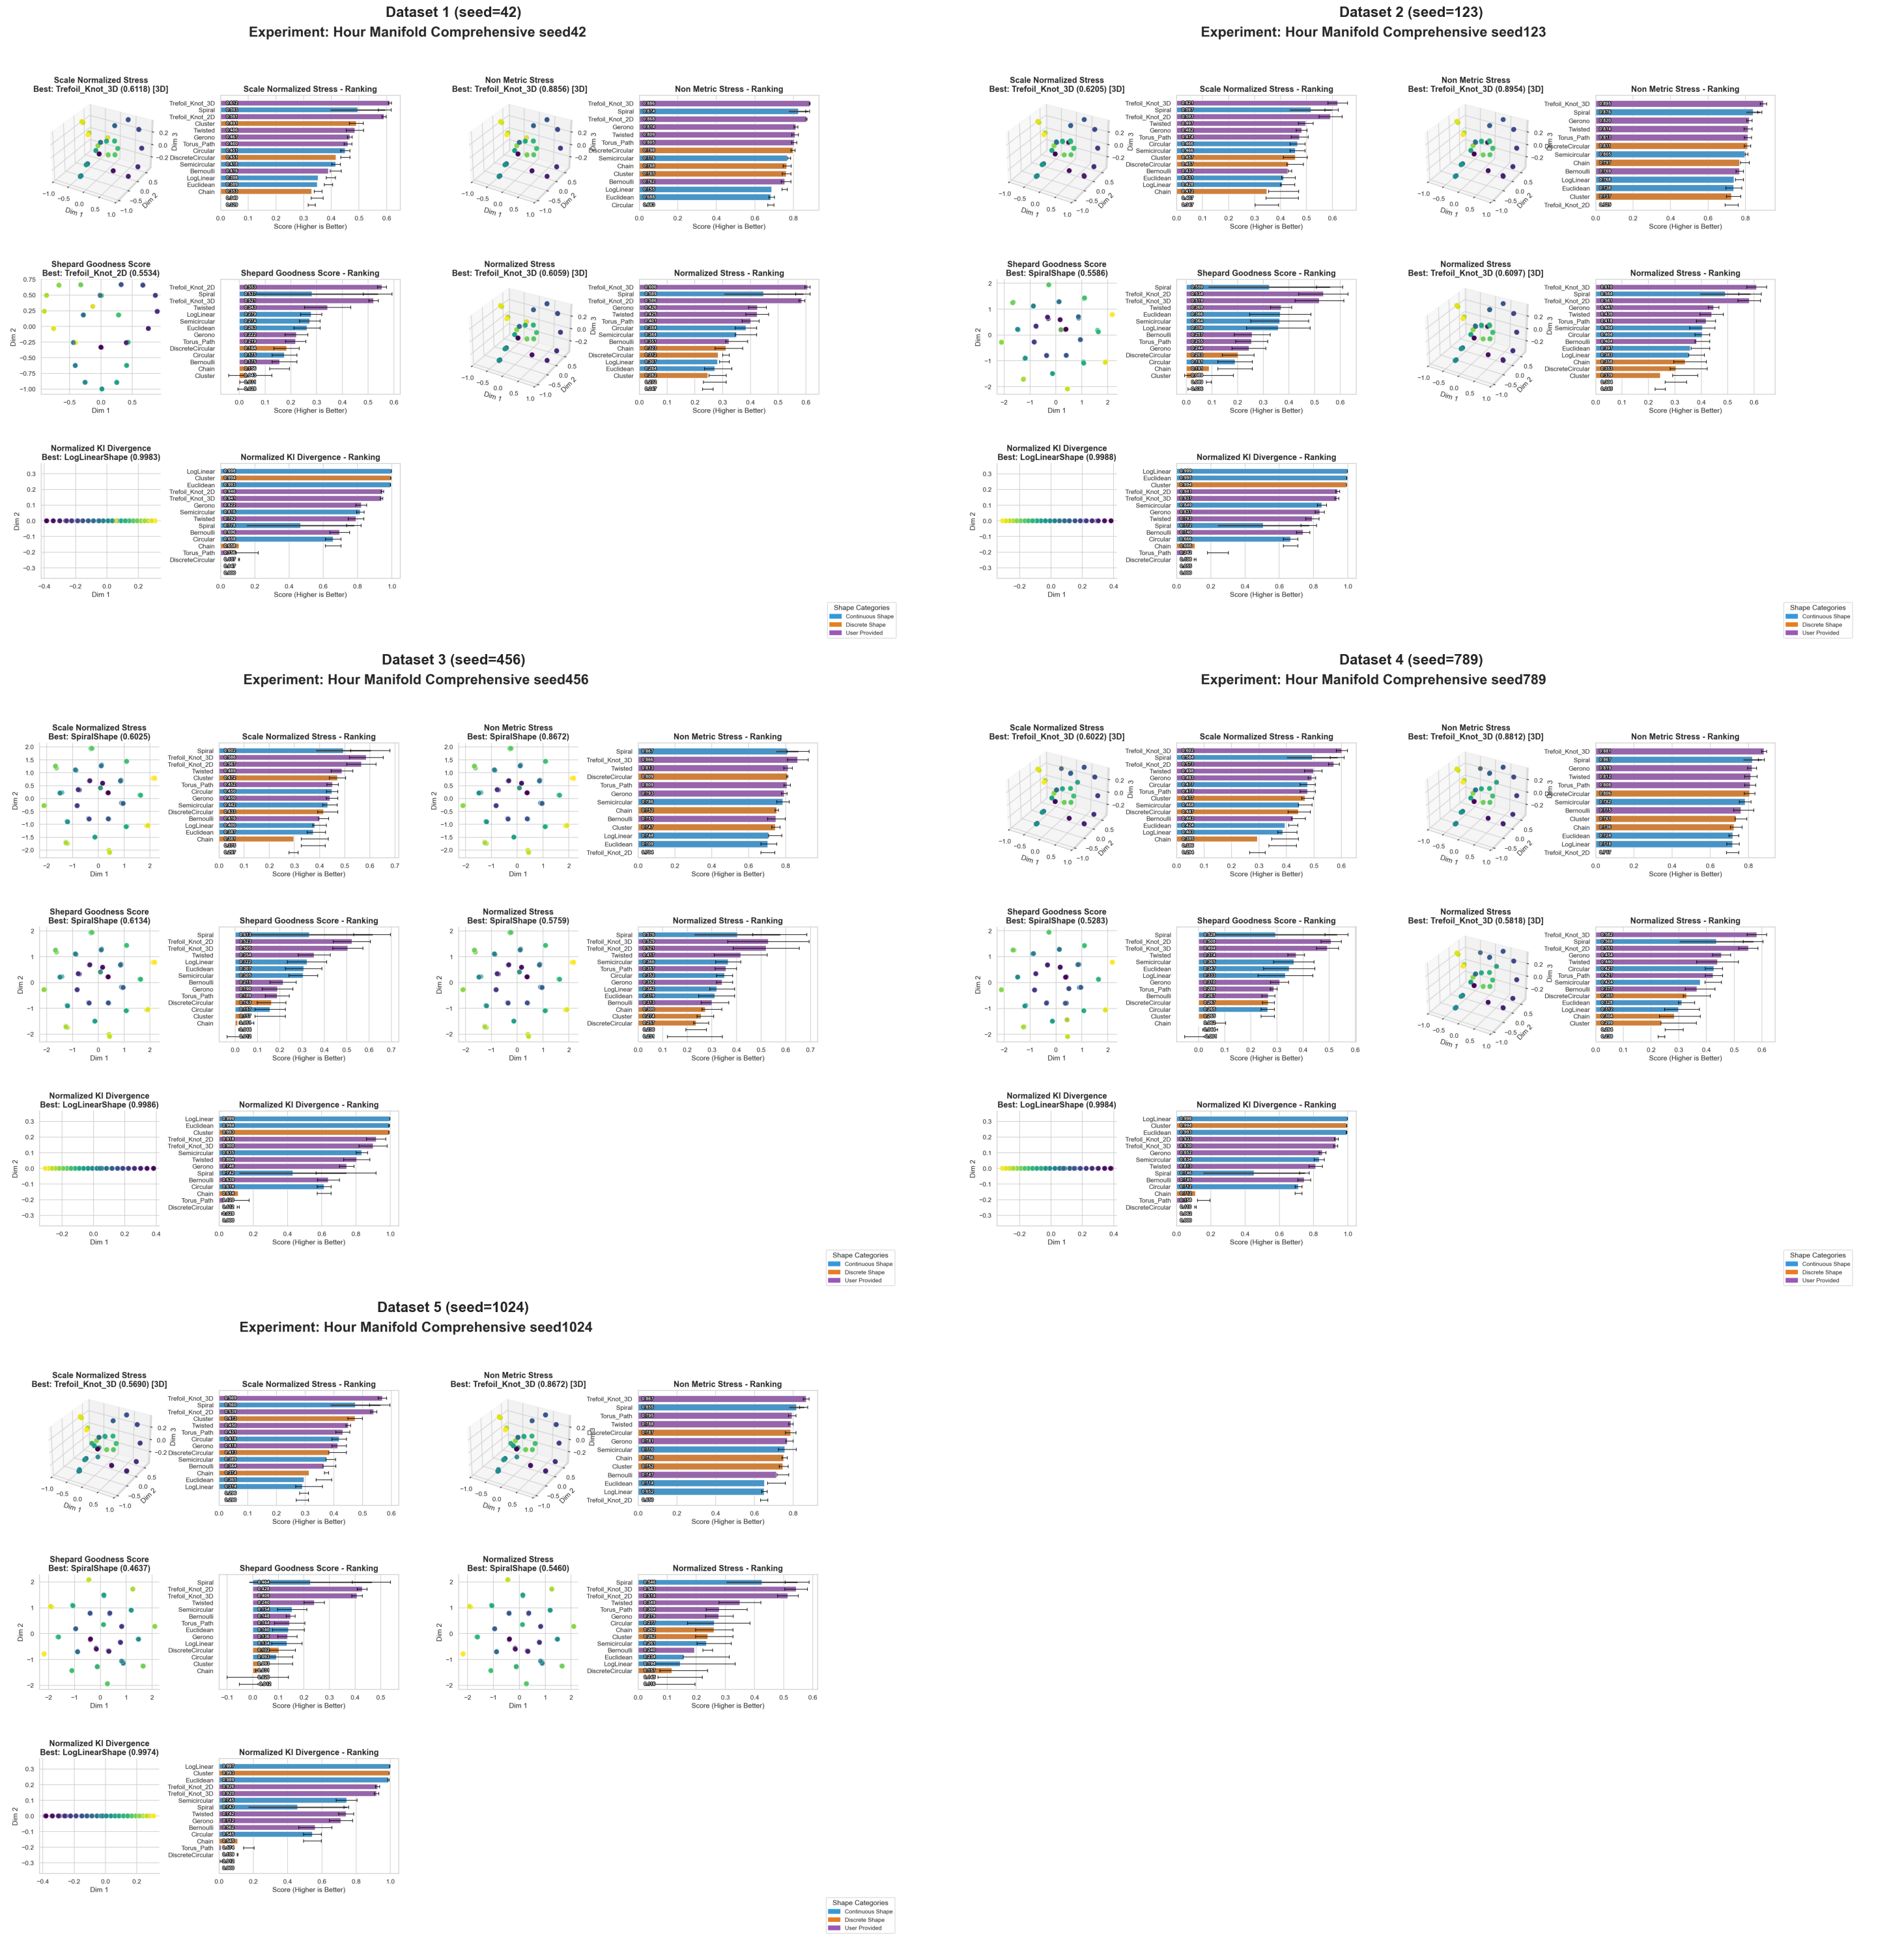

In [14]:
if visualization_paths:
    n_plots = len(visualization_paths)
    n_cols = min(2, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15 * n_cols, 10 * n_rows))
    if n_plots == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for idx, viz_path in enumerate(visualization_paths):
        img = Image.open(viz_path)
        axes[idx].imshow(img)
        axes[idx].axis("off")
        axes[idx].set_title(f"Dataset {idx + 1} (seed={datasets[idx]['seed']})", fontsize=16, fontweight="bold")

    for idx in range(len(visualization_paths), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()
else:
    print("No visualization plots found.")

## 11. Aggregate Results Across All Datasets

### Statistical Aggregation

Given a stress metric, for each shape, we compute:
- **Mean score**: Central tendency across datasets
- **Std**: Variability 
- **Min/Max**: Range of performance
- **Count**: Number of measurements (should be n_datasets)

**Key metric**: Mean ± Std provides confidence in shape ranking.
**Note**: If there is no metric given, we aggreagte the result over the mean of the scores for different metrics

In [15]:
stress = "mean_scale_normalized_stress"
shape_col = None
for col in combined_results.columns:
    if "shape" in col.lower() and shape_col is None:
        shape_col = col
        break
metric_cols = [c for c in combined_results.columns if c.startswith("mean_")]
if not metric_cols:
    metric_cols = [
        c for c in combined_results.columns if "mean" in c.lower() and ("stress" in c.lower() or "shepard" in c.lower())
    ]
combined_results = combined_results.copy()
if stress is not None and stress in combined_results.columns:
    combined_results["score"] = combined_results[stress]
else:
    combined_results["score"] = combined_results[metric_cols].mean(axis=1)

has_score = (stress is not None and stress in combined_results.columns) or len(metric_cols) > 0
if shape_col and has_score:
    aggregated = combined_results.groupby(shape_col)["score"].agg(["mean", "std", "min", "max", "count"]).reset_index()
    aggregated.columns = ["Shape", "Mean_Score", "Std_Score", "Min_Score", "Max_Score", "N_Runs"]
    aggregated = aggregated.sort_values("Mean_Score", ascending=False)
    aggregated["CV"] = (aggregated["Std_Score"] / aggregated["Mean_Score"]) * 100

    print("=" * 120)
    print("AGGREGATED RESULTS:")
    print("=" * 120)
    print(f"\nStatistics computed over {len(datasets)} independent datasets")
    print(f"Each shape tested with {N_FOLDS}-fold cross-validation\n")
    print(aggregated.to_string(index=False, float_format=lambda x: f"{x:.4f}"))
    print("\n" + "=" * 120)

    best_shape = aggregated.iloc[0]["Shape"]
    best_mean_score = aggregated.iloc[0]["Mean_Score"]
    best_std_score = aggregated.iloc[0]["Std_Score"]
    best_cv = aggregated.iloc[0]["CV"]

    print(f"\nBest Shape: {best_shape}")
    print(f"  Mean Score: {best_mean_score:.4f}")
    print(f"  Std: ±{best_std_score:.4f}")
    print(f"  Coefficient of Variation: {best_cv:.1f}%")
    print(
        f"  95% CI (approx): [{best_mean_score - 2 * best_std_score:.4f}, {best_mean_score + 2 * best_std_score:.4f}]"
    )
else:
    print("Could not identify shape and score columns for aggregation.")
    print(f"Available columns: {list(combined_results.columns)}")

AGGREGATED RESULTS:

Statistics computed over 5 independent datasets
Each shape tested with 5-fold cross-validation

                Shape  Mean_Score  Std_Score  Min_Score  Max_Score  N_Runs      CV
      Trefoil_Knot_3D      0.5980     0.0206     0.5690     0.6205       5  3.4391
      Trefoil_Knot_2D      0.5724     0.0219     0.5388     0.5929       5  3.8326
          SpiralShape      0.4951     0.0988     0.3870     0.6025      10 19.9485
              Twisted      0.4840     0.0196     0.4501     0.4978       5  4.0561
         ClusterShape      0.4722     0.0122     0.4569     0.4907       5  2.5872
               Gerono      0.4592     0.0321     0.4131     0.4925       5  6.9897
           Torus_Path      0.4589     0.0185     0.4312     0.4770       5  4.0270
        CircularShape      0.4524     0.0211     0.4180     0.4774      10  4.6680
    SemicircularShape      0.4255     0.0326     0.3741     0.4573       5  7.6549
DiscreteCircularShape      0.4184     0.0220     0.38

## 12. Statistical Comparison: Hypotheses vs. Baselines

### Statistical Significance Testing

**Objective:** Rigorously determine if the proposed topological models (Figure-8, Torus, Trefoil) provide a significantly better fit than the best-performing standard baseline.

**Formal Hypothesis:**
* **Null Hypothesis ($H_0$):** The proposed topological hypothesis yields a stress score equal to or worse (higher) than the best baseline model.
* **Alternative Hypothesis ($H_1$):** The proposed topological hypothesis yields a statistically significantly lower stress score (better fit).

**Method:** Independent two-sample t-test (one-tailed) comparing the distribution of stress scores across all cross-validation folds and seeds.

In [16]:
if "combined_results" not in locals() or combined_results.empty:
    print("Error: 'combined_results' dataframe not found or empty. Please run previous cells.")
else:
    if "score" not in combined_results.columns:
        valid_cols = [c for c in combined_results.columns if "scale_normalized" in c and "mean" in c]
        if valid_cols:
            combined_results["score"] = combined_results[valid_cols[0]]
        else:
            metric_cols = [c for c in combined_results.columns if c.startswith("mean_")]
            combined_results["score"] = combined_results[metric_cols].mean(axis=1)

    shape_col = next((col for col in combined_results.columns if "shape" in col.lower()), None)

    if not shape_col:
        print("Error: Could not find shape column in combined_results")
    else:
        topo_keywords = ["Gerono", "Bernoulli", "Twisted", "Torus", "Trefoil", "UserProvided"]

        is_topo = combined_results[shape_col].apply(lambda x: any(k in x for k in topo_keywords))

        standard_df = combined_results[~is_topo].copy()
        topo_df = combined_results[is_topo].copy()

        if standard_df.empty or topo_df.empty:
            print("Error: Could not split results into Baseline and Topological sets.")
            print(f"Standard count: {len(standard_df)}, Topological count: {len(topo_df)}")
        else:

            def aggregate_scores(df):
                """Aggregate score by shape/variant (mean, std, count)."""
                agg = df.groupby(shape_col)["score"].agg(["mean", "std", "count"]).reset_index()
                agg.columns = ["Variant", "Mean_Score", "Std_Score", "N_Runs"]
                return agg.sort_values("Mean_Score", ascending=False)

            agg_standard = aggregate_scores(standard_df)
            agg_topo = aggregate_scores(topo_df)

            best_standard_shape = agg_standard.iloc[0]["Variant"]
            best_hypothesis = agg_topo.iloc[0]["Variant"]

            standard_scores = standard_df[standard_df[shape_col] == best_standard_shape]["score"].values
            hypothesis_scores = topo_df[topo_df[shape_col] == best_hypothesis]["score"].values

            t_stat, p_value = stats.ttest_ind(hypothesis_scores, standard_scores, alternative="greater")

            if "Torus" in best_hypothesis or "Trefoil" in best_hypothesis:
                hyp_type = "Toroidal/Knot"
            else:
                hyp_type = "Figure-8"

            pooled_std = np.sqrt((standard_scores.std(ddof=1) ** 2 + hypothesis_scores.std(ddof=1) ** 2) / 2)
            if pooled_std == 0:
                cohens_d = 0.0
            else:
                cohens_d = (hypothesis_scores.mean() - standard_scores.mean()) / pooled_std

            sig_level = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "n.s."
            effect_size_label = "small" if abs(cohens_d) < 0.5 else "medium" if abs(cohens_d) < 0.8 else "large"

            print("=" * 100)
            print("STATISTICAL COMPARISON: BASELINE vs TOPOLOGICAL HYPOTHESES")
            print("=" * 100)
            print(f"\nBest Standard Shape: {best_standard_shape}")
            print(f"  Mean Score: {standard_scores.mean():.4f} ± {standard_scores.std():.4f}")
            print(f"  n = {len(standard_scores)}")

            print(f"\nBest Topological Hypothesis: {best_hypothesis} ({hyp_type})")
            print(f"  Mean Score: {hypothesis_scores.mean():.4f} ± {hypothesis_scores.std():.4f}")
            print(f"  n = {len(hypothesis_scores)}")

            print("\nTwo-sample t-test (one-tailed, H1: hypothesis > baseline):")
            print(f"  t-statistic: {t_stat:.4f}")
            print(f"  p-value: {p_value:.6f}")
            print(f"  Significance: {sig_level}")

            if p_value < 0.05:
                print(f"\n {hyp_type} hypothesis is SUPPORTED (p < 0.05)")
            else:
                print(f"\n{hyp_type} hypothesis is NOT supported (p >= 0.05)")

            print(f"\nCohen's d (effect size): {cohens_d:.3f}")
            print(f"Interpretation: {effect_size_label} effect")
            print("\n" + "=" * 100)

STATISTICAL COMPARISON: BASELINE vs TOPOLOGICAL HYPOTHESES

Best Standard Shape: SpiralShape
  Mean Score: 0.4951 ± 0.0937
  n = 10

Best Topological Hypothesis: Trefoil_Knot_3D (Toroidal/Knot)
  Mean Score: 0.5980 ± 0.0184
  n = 5

Two-sample t-test (one-tailed, H1: hypothesis > baseline):
  t-statistic: 2.2627
  p-value: 0.020712
  Significance: *

 Toroidal/Knot hypothesis is SUPPORTED (p < 0.05)

Cohen's d (effect size): 1.441
Interpretation: large effect



## 13. Comprehensive Visualizations


### 13.1 Consistency Analysis: Coefficient of Variation

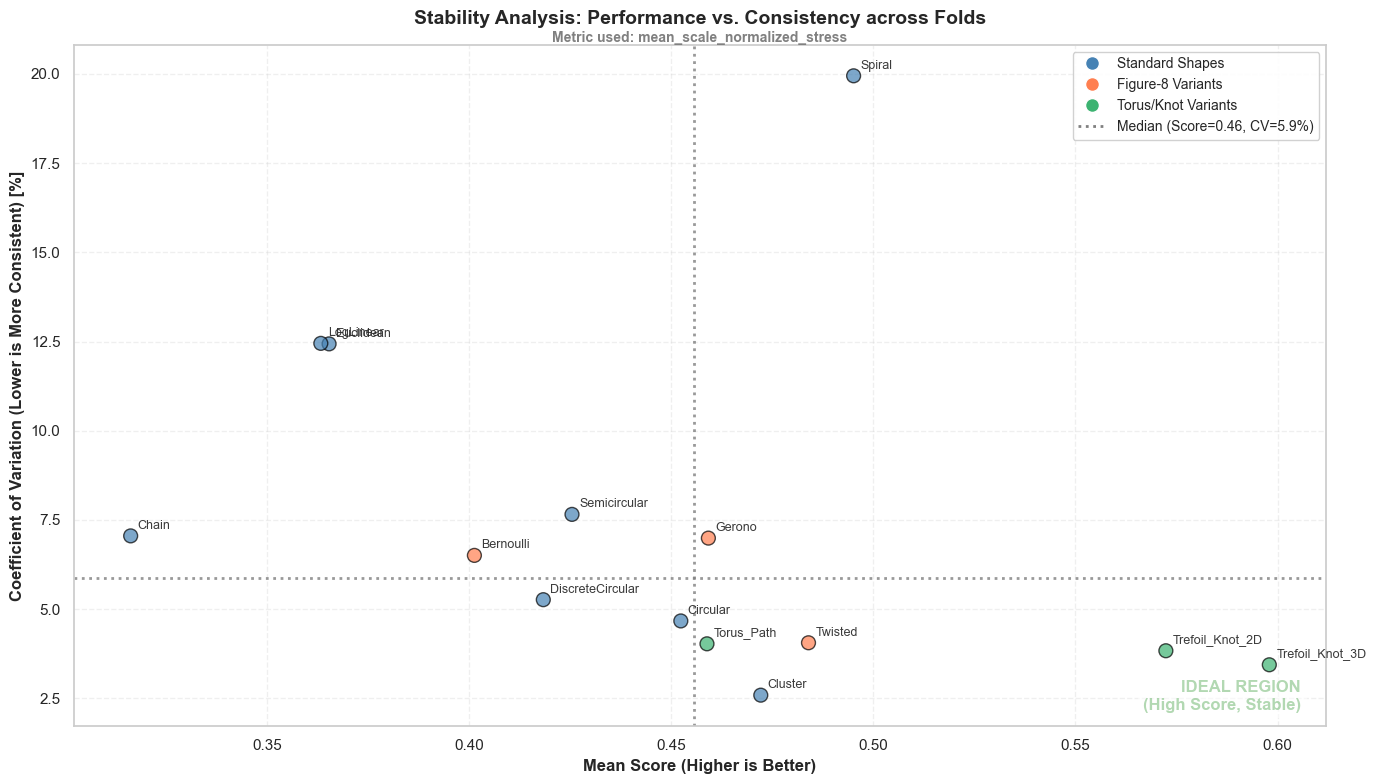

In [17]:
if "combined_results" not in locals() or combined_results.empty:
    print("Error: 'combined_results' dataframe not found. Please run previous cells.")
else:
    shape_col = next((col for col in combined_results.columns if "shape" in col.lower()), None)

    if "score" not in combined_results.columns:
        valid_cols = [c for c in combined_results.columns if "scale_normalized" in c and "mean" in c]
        if valid_cols:
            combined_results["score"] = combined_results[valid_cols[0]]
        else:
            metric_cols = [c for c in combined_results.columns if c.startswith("mean_")]
            combined_results["score"] = combined_results[metric_cols].mean(axis=1)

    agg_all = combined_results.groupby(shape_col)["score"].agg(["mean", "std"]).reset_index()
    agg_all.columns = ["Config", "Mean_Score", "Std_Score"]
    agg_all["CV"] = (agg_all["Std_Score"] / agg_all["Mean_Score"]) * 100

    topo_keywords = ["Gerono", "Bernoulli", "Twisted", "Torus", "Trefoil", "UserProvided"]

    def get_type(name):
        """Return 'Standard', 'Figure-8', or 'Torus' from variant name."""
        is_topo = any(k in name for k in topo_keywords)

        if not is_topo:
            return "Standard"
        elif "Torus" in name or "Trefoil" in name:
            return "Torus"
        else:
            return "Figure-8"

    agg_all["Type"] = agg_all["Config"].apply(get_type)

    # --- PLOTTING ---
    fig, ax = plt.subplots(figsize=(14, 8))

    color_map = {"Standard": "steelblue", "Figure-8": "coral", "Torus": "mediumseagreen"}
    colors = [color_map[t] for t in agg_all["Type"]]
    sizes = 100

    scatter = ax.scatter(
        agg_all["Mean_Score"], agg_all["CV"], s=sizes, c=colors, alpha=0.7, edgecolors="black", linewidths=1.0
    )

    for idx, row in agg_all.iterrows():
        ax.annotate(
            row["Config"].replace("Shape", "").replace("UserProvided", ""),
            (row["Mean_Score"], row["CV"]),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=9,
            alpha=0.9,
        )

    median_score = agg_all["Mean_Score"].median()
    median_cv = agg_all["CV"].median()

    ax.axvline(x=median_score, color="gray", linestyle=":", linewidth=2, alpha=0.8)
    ax.axhline(y=median_cv, color="gray", linestyle=":", linewidth=2, alpha=0.8)

    ax.set_xlabel("Mean Score (Higher is Better)", fontsize=12, fontweight="bold")
    ax.set_ylabel("Coefficient of Variation (Lower is More Consistent) [%]", fontsize=12, fontweight="bold")
    ax.set_title("Stability Analysis: Performance vs. Consistency across Folds", fontsize=14, fontweight="bold", pad=15)
    ax.text(
        0.5,
        1,
        f"Metric used: {stress}",
        transform=ax.transAxes,
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
        color="gray",
    )
    ax.text(
        0.98,
        0.02,
        "IDEAL REGION\n(High Score, Stable)",
        transform=ax.transAxes,
        ha="right",
        va="bottom",
        color="green",
        alpha=0.3,
        fontsize=12,
        fontweight="bold",
        bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"),
    )

    ax.grid(True, alpha=0.3, linestyle="--")

    legend_elements = [
        Line2D([0], [0], marker="o", color="w", markerfacecolor="steelblue", markersize=10, label="Standard Shapes"),
        Line2D([0], [0], marker="o", color="w", markerfacecolor="coral", markersize=10, label="Figure-8 Variants"),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor="mediumseagreen",
            markersize=10,
            label="Torus/Knot Variants",
        ),
        Line2D(
            [0],
            [0],
            color="gray",
            linestyle=":",
            linewidth=2,
            label=f"Median (Score={median_score:.2f}, CV={median_cv:.1f}%)",
        ),
    ]
    ax.legend(handles=legend_elements, fontsize=10, loc="best", frameon=True, framealpha=0.9)

    plt.tight_layout()
    plt.show()

### 13.2 Detailed Distribution: Violin Plots

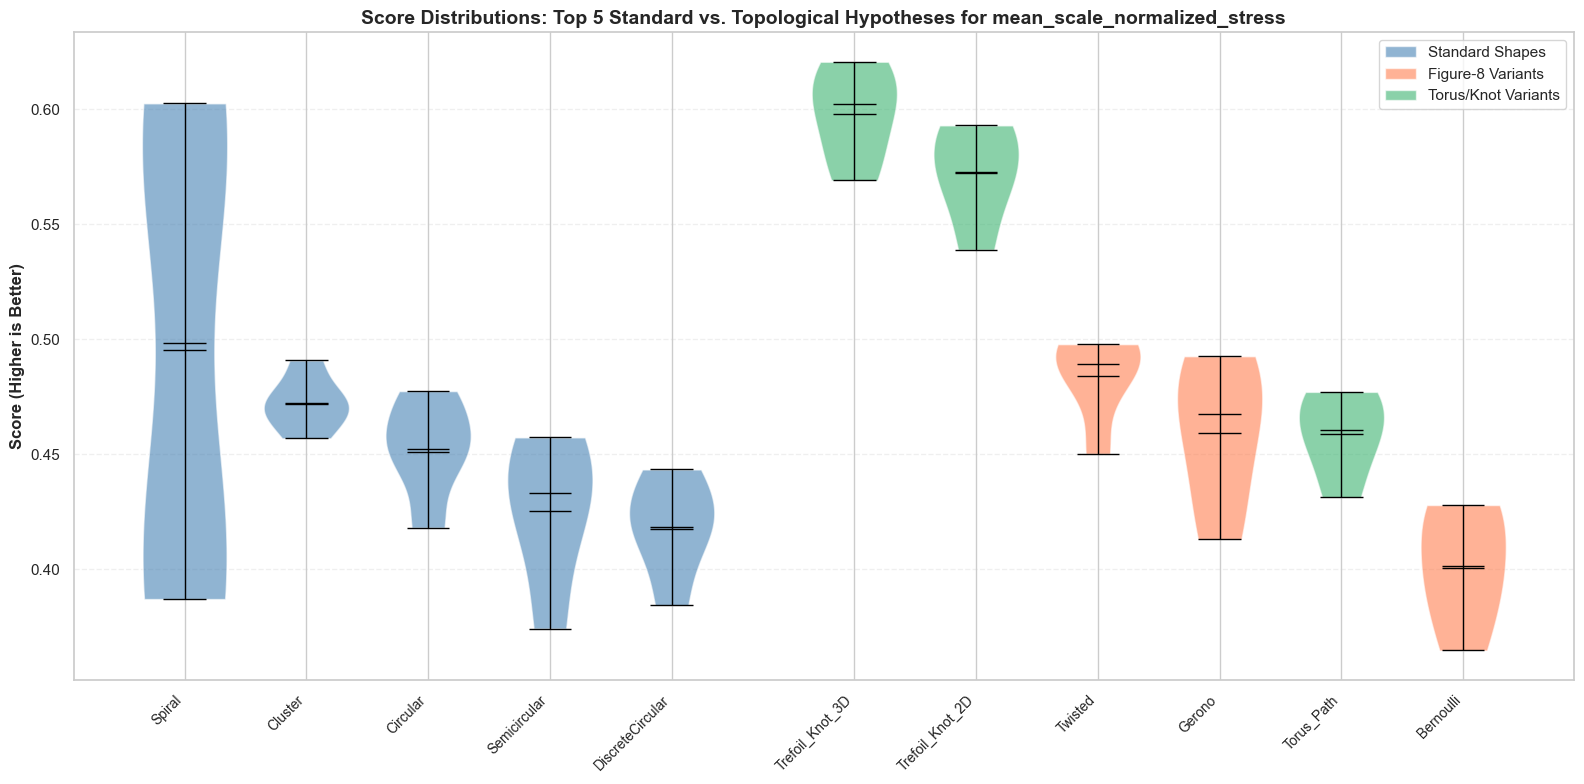


Violin plot interpretation:
  - Width: Distribution density (frequency of scores)
  - Horizontal lines: Min, Max, Mean, Median
  - Height: Range of scores across cross-validation folds


In [18]:
if "combined_results" not in locals() or combined_results.empty:
    print("Error: 'combined_results' dataframe not found. Please run previous cells.")
else:
    shape_col = next((col for col in combined_results.columns if "shape" in col.lower()), None)

    if "score" not in combined_results.columns:
        valid_cols = [c for c in combined_results.columns if "scale_normalized" in c and "mean" in c]
        if valid_cols:
            combined_results["score"] = combined_results[valid_cols[0]]
        else:
            metric_cols = [c for c in combined_results.columns if c.startswith("mean_")]
            combined_results["score"] = combined_results[metric_cols].mean(axis=1)

    topo_keywords = ["Gerono", "Bernoulli", "Twisted", "Torus", "Trefoil", "UserProvided"]

    is_topo = combined_results[shape_col].apply(lambda x: any(k in x for k in topo_keywords))

    agg_standard = combined_results[~is_topo].groupby(shape_col)["score"].mean().sort_values(ascending=False)
    top_5_standard = agg_standard.head(5).index.tolist()

    agg_topo = combined_results[is_topo].groupby(shape_col)["score"].mean().sort_values(ascending=False)
    topo_variants = agg_topo.index.tolist()

    fig, ax = plt.subplots(figsize=(16, 8))

    positions = []
    labels = []
    pos = 0

    for shape in top_5_standard:
        data = combined_results[combined_results[shape_col] == shape]["score"].values
        parts = ax.violinplot([data], positions=[pos], widths=0.7, showmeans=True, showmedians=True)
        for pc in parts["bodies"]:
            pc.set_facecolor("steelblue")
            pc.set_alpha(0.6)
        for partname in ("cbars", "cmins", "cmaxes", "cmeans", "cmedians"):
            if partname in parts:
                parts[partname].set_edgecolor("black")
                parts[partname].set_linewidth(1)

        positions.append(pos)
        labels.append(shape.replace("Shape", ""))
        pos += 1

    if top_5_standard and topo_variants:
        pos += 0.5

    for variant in topo_variants:
        data = combined_results[combined_results[shape_col] == variant]["score"].values
        parts = ax.violinplot([data], positions=[pos], widths=0.7, showmeans=True, showmedians=True)

        is_torus = "Torus" in variant or "Trefoil" in variant
        variant_color = "mediumseagreen" if is_torus else "coral"

        for pc in parts["bodies"]:
            pc.set_facecolor(variant_color)
            pc.set_alpha(0.6)
        for partname in ("cbars", "cmins", "cmaxes", "cmeans", "cmedians"):
            if partname in parts:
                parts[partname].set_edgecolor("black")
                parts[partname].set_linewidth(1)

        positions.append(pos)
        labels.append(variant.replace("UserProvided", "").replace("Shape", ""))
        pos += 1

    ax.set_xticks(positions)
    ax.set_xticklabels(labels, rotation=45, ha="right", fontsize=10)
    ax.set_ylabel("Score (Higher is Better)", fontsize=12, fontweight="bold")
    ax.set_title(
        f"Score Distributions: Top 5 Standard vs. Topological Hypotheses for {stress}", fontsize=14, fontweight="bold"
    )
    ax.grid(axis="y", alpha=0.3, linestyle="--")

    legend_elements = [
        Patch(facecolor="steelblue", alpha=0.6, label="Standard Shapes"),
        Patch(facecolor="coral", alpha=0.6, label="Figure-8 Variants"),
        Patch(facecolor="mediumseagreen", alpha=0.6, label="Torus/Knot Variants"),
    ]
    ax.legend(handles=legend_elements, fontsize=11, loc="best")

    plt.tight_layout()
    plt.show()

    print("\nViolin plot interpretation:")
    print("  - Width: Distribution density (frequency of scores)")
    print("  - Horizontal lines: Min, Max, Mean, Median")
    print("  - Height: Range of scores across cross-validation folds")

## 14. Final Summary and Conclusions

### Experimental Summary

In [19]:
print("=" * 100)
print("EXPERIMENTAL SUMMARY")
print("=" * 100)

if "combined_results" not in locals() or combined_results.empty:
    print("Error: 'combined_results' dataframe not found. Please run previous cells.")
else:
    shape_col = next((col for col in combined_results.columns if "shape" in col.lower()), None)

    if "score" not in combined_results.columns:
        valid_cols = [c for c in combined_results.columns if "scale_normalized" in c and "mean" in c]
        if valid_cols:
            combined_results["score"] = combined_results[valid_cols[0]]
        else:
            metric_cols = [c for c in combined_results.columns if c.startswith("mean_")]
            combined_results["score"] = combined_results[metric_cols].mean(axis=1)

    topo_keywords = ["Gerono", "Bernoulli", "Twisted", "Torus", "Trefoil", "UserProvided"]
    is_topo = combined_results[shape_col].apply(lambda x: any(k in x for k in topo_keywords))

    agg_standard = (
        combined_results[~is_topo].groupby(shape_col)["score"].agg(["mean", "std"]).sort_values("mean", ascending=False)
    )

    agg_topo = (
        combined_results[is_topo].groupby(shape_col)["score"].agg(["mean", "std"]).sort_values("mean", ascending=False)
    )

    # --- PRINT OUTPUT ---

    print("\n1. BASELINE SHAPES (Top 5):")
    print("-" * 100)
    if not agg_standard.empty:
        for idx, (name, row) in enumerate(agg_standard.head(5).iterrows()):
            clean_name = name.replace("Shape", "")
            print(f"   {idx + 1}. {clean_name:25s} Score: {row['mean']:.4f} ± {row['std']:.4f}")
    else:
        print("   (No baseline shapes found)")

    print("\n2. TOPOLOGICAL HYPOTHESES:")
    print("-" * 100)
    if not agg_topo.empty:
        for idx, (name, row) in enumerate(agg_topo.iterrows()):
            clean_name = name.replace("UserProvided", "").replace("Shape", "")
            hyp_type = "Torus" if ("Torus" in name or "Trefoil" in name) else "Figure-8"
            print(f"   {idx + 1}. {clean_name:25s} [{hyp_type:10s}] Score: {row['mean']:.4f} ± {row['std']:.4f}")
    else:
        print("   (No topological hypotheses found)")

    if not agg_standard.empty and not agg_topo.empty:
        best_base_name = agg_standard.index[0]
        best_base_score = agg_standard.iloc[0]["mean"]
        best_base_std = agg_standard.iloc[0]["std"]

        best_topo_name = agg_topo.index[0]
        best_topo_score = agg_topo.iloc[0]["mean"]
        best_topo_std = agg_topo.iloc[0]["std"]

        hyp_type = "Torus" if ("Torus" in best_topo_name or "Trefoil" in best_topo_name) else "Figure-8"

        score_diff = best_topo_score - best_base_score
        improvement_pct = (score_diff / best_base_score) * 100 if best_base_score != 0 else 0

        print("\n3. BEST COMPARISON:")
        print("-" * 100)
        print(f"   Baseline:     {best_base_name.replace('Shape', ''):25s} {best_base_score:.4f} ± {best_base_std:.4f}")
        topo_label = best_topo_name.replace("UserProvided", "").replace("Shape", "")
        print(f"   Hypothesis:   {topo_label:25s} [{hyp_type}] {best_topo_score:.4f} ± {best_topo_std:.4f}")
        print(f"   Difference:   {score_diff:+.4f} ({improvement_pct:+.1f}%)")

        if "p_value" in locals():
            print(f"   t-test:       p = {p_value:.6f}")
            if p_value < 0.05:
                print(f"   Result:       ✓ {hyp_type} hypothesis SUPPORTED (p < 0.05)")
            else:
                print(f"   Result:       ✗ {hyp_type} hypothesis NOT supported (p >= 0.05)")
        else:
            print("   (t-test statistics not available in local scope)")

    print("\n4. METHODOLOGY:")
    print("-" * 100)
    layer_info = GPT2_LAYER if "GPT2_LAYER" in locals() else "?"
    n_seeds = len(datasets) if "datasets" in locals() else "?"
    n_folds_info = N_FOLDS if "N_FOLDS" in locals() else "?"

    print(f"   Model:           GPT-2 Small, Layer {layer_info}/12")
    print(f"   Datasets:        {n_seeds} seeds")
    print(f"   Cross-validation: {n_folds_info}-fold")
    if "agg_standard" in locals():
        print(f"   Baseline shapes: {len(agg_standard)} variants")
    if "agg_topo" in locals():
        print(f"   Hypotheses:      {len(agg_topo)} variants")

print("\n" + "=" * 100)

EXPERIMENTAL SUMMARY

1. BASELINE SHAPES (Top 5):
----------------------------------------------------------------------------------------------------
   1. Spiral                    Score: 0.4951 ± 0.0988
   2. Cluster                   Score: 0.4722 ± 0.0122
   3. Circular                  Score: 0.4524 ± 0.0211
   4. Semicircular              Score: 0.4255 ± 0.0326
   5. DiscreteCircular          Score: 0.4184 ± 0.0220

2. TOPOLOGICAL HYPOTHESES:
----------------------------------------------------------------------------------------------------
   1. Trefoil_Knot_3D           [Torus     ] Score: 0.5980 ± 0.0206
   2. Trefoil_Knot_2D           [Torus     ] Score: 0.5724 ± 0.0219
   3. Twisted                   [Figure-8  ] Score: 0.4840 ± 0.0196
   4. Gerono                    [Figure-8  ] Score: 0.4592 ± 0.0321
   5. Torus_Path                [Torus     ] Score: 0.4589 ± 0.0185
   6. Bernoulli                 [Figure-8  ] Score: 0.4013 ± 0.0261

3. BEST COMPARISON:
----------------